In [3]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import rioxarray
from pathlib import Path
import pyproj
import scipy
from scipy.signal import savgol_filter
from dask.distributed import Client
import dask
import rasterio as rio
import numpy as np
import seaborn as sb

In [4]:
client = Client()

/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53801 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53801/status,
Dashboard: http://127.0.0.1:53801/status,Workers: 3
Total threads: 6,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53802,Workers: 3
Dashboard: http://127.0.0.1:53801/status,Total threads: 6
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:53811,Total threads: 2
Dashboard: http://127.0.0.1:53816/status,Memory: 10.67 GiB
Nanny: tcp://127.0.0.1:53807,


---

Prototyping

In [13]:
testfile = Path("/Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")

After testing, we don't need `rioxarray` to deal with this data. But we keep the library call in the back pocket. 

In [14]:
#testdata_forcrs = rioxarray.open_rasterio(testfile, chunks=(-1, 256, 256), default_name="reflectance", variable='reflectance')
testdata = xr.open_dataset(testfile, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400})
testdata

<xarray.Dataset>
Dimensions:      (band: 459, x: 1226, y: 8506)
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.354e+05 4.354e+05 ... 4.366e+05 4.366e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 400, 200), meta=np.ndarray>

In [15]:
testdata.attrs['long_name'] = "spectral reflectance, %*100"
testdata.attrs['name'] = "spectral reflectance, %*100"
testdata['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"

In [16]:
testdata.band_data

<xarray.DataArray 'band_data' (band: 459, y: 8506, x: 1226)>
dask.array<open_dataset-b0b0383fe8a00c2136951cd0422e4a0eband_data, shape=(459, 8506, 1226), dtype=float32, chunksize=(1, 400, 200), chunktype=numpy.ndarray>
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.354e+05 4.354e+05 ... 4.366e+05 4.366e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    long_name:                 spectral reflectance, %*100
    acquisition_time:          2020-08-30T23:08:24.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 435424.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1226
    sun_azimuth:               202.02
    sun_elevation:             31.880000000000003
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

The CRS is used to create a transform to translate lat/lon into UTM 6N coordinates

In [27]:
testdata.y

<xarray.DataArray 'y' (y: 8506)>
array([7183053., 7183052., 7183051., ..., 7174550., 7174549., 7174548.])
Coordinates:
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...

In [17]:
testdata.band_data.attrs['coordinate_system_string']

'PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-147.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'

In [19]:
crs = pyproj.CRS.from_wkt(testdata.band_data.attrs['coordinate_system_string'])
transformer = pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(4326), crs, always_xy=True) 
lonlat_to_crs = lambda lon, lat: transformer.transform(lon, lat)    

x and y are just a sample location

In [20]:
x, y = transformer.transform(-148.35, 64.7)

In [21]:
x, y

(435629.2061170959, 7175706.511372154)

xarray correctly picks up the nodata value

In [24]:
testdata.band_data[:, 1000, 1000].values

array([  130.,   102.,    87.,    73.,   139.,   131.,   114.,   131.,
         127.,   159.,   157.,   170.,   146.,   157.,   146.,   176.,
         168.,   147.,   137.,   156.,   152.,   177.,   175.,   167.,
         191.,   188.,   195.,   213.,   212.,   225.,   244.,   261.,
         261.,   287.,   359.,   346.,   392.,   445.,   503.,   490.,
         508.,   527.,   539.,   578.,   572.,   600.,   608.,   614.,
         571.,   552.,   545.,   547.,   526.,   534.,   524.,   490.,
         497.,   511.,   488.,   489.,   489.,   480.,   485.,   455.,
         446.,   448.,   448.,   442.,   442.,   437.,   411.,   440.,
         423.,   414.,   394.,   396.,   375.,   379.,   354.,   346.,
         327.,   319.,   285.,   302.,   302.,   313.,   311.,   372.,
         534.,   695.,   864.,  1008.,  1168.,  1348.,  1488.,  1675.,
        1808.,  1969.,  2129.,  2289.,  2450.,  2610.,  2770.,  2981.,
        3118.,  3155.,  3259.,  3251.,  3283.,  3316.,  3349.,  3381.,
      

Now let's select N random locations inside the data area (ie, not NaN). 

In [207]:
rng = np.random.default_rng(2021)

In [209]:
selectionarray = testdata.band_data.sel(band=1).to_masked_array(copy=False)
selectionarray.shape

(8506, 1226)

In [210]:
weights = ~selectionarray.mask + 0 #Assign False = 0, True = 1
normalized = weights.ravel()/float(weights.sum())
    
index = rng.choice(
    selectionarray.size, 
    size=1000, 
    replace=False, 
    p=normalized
)        
idy, idx = np.unravel_index(index, selectionarray.shape)


Text(0.5, 1.0, '20200830-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq')

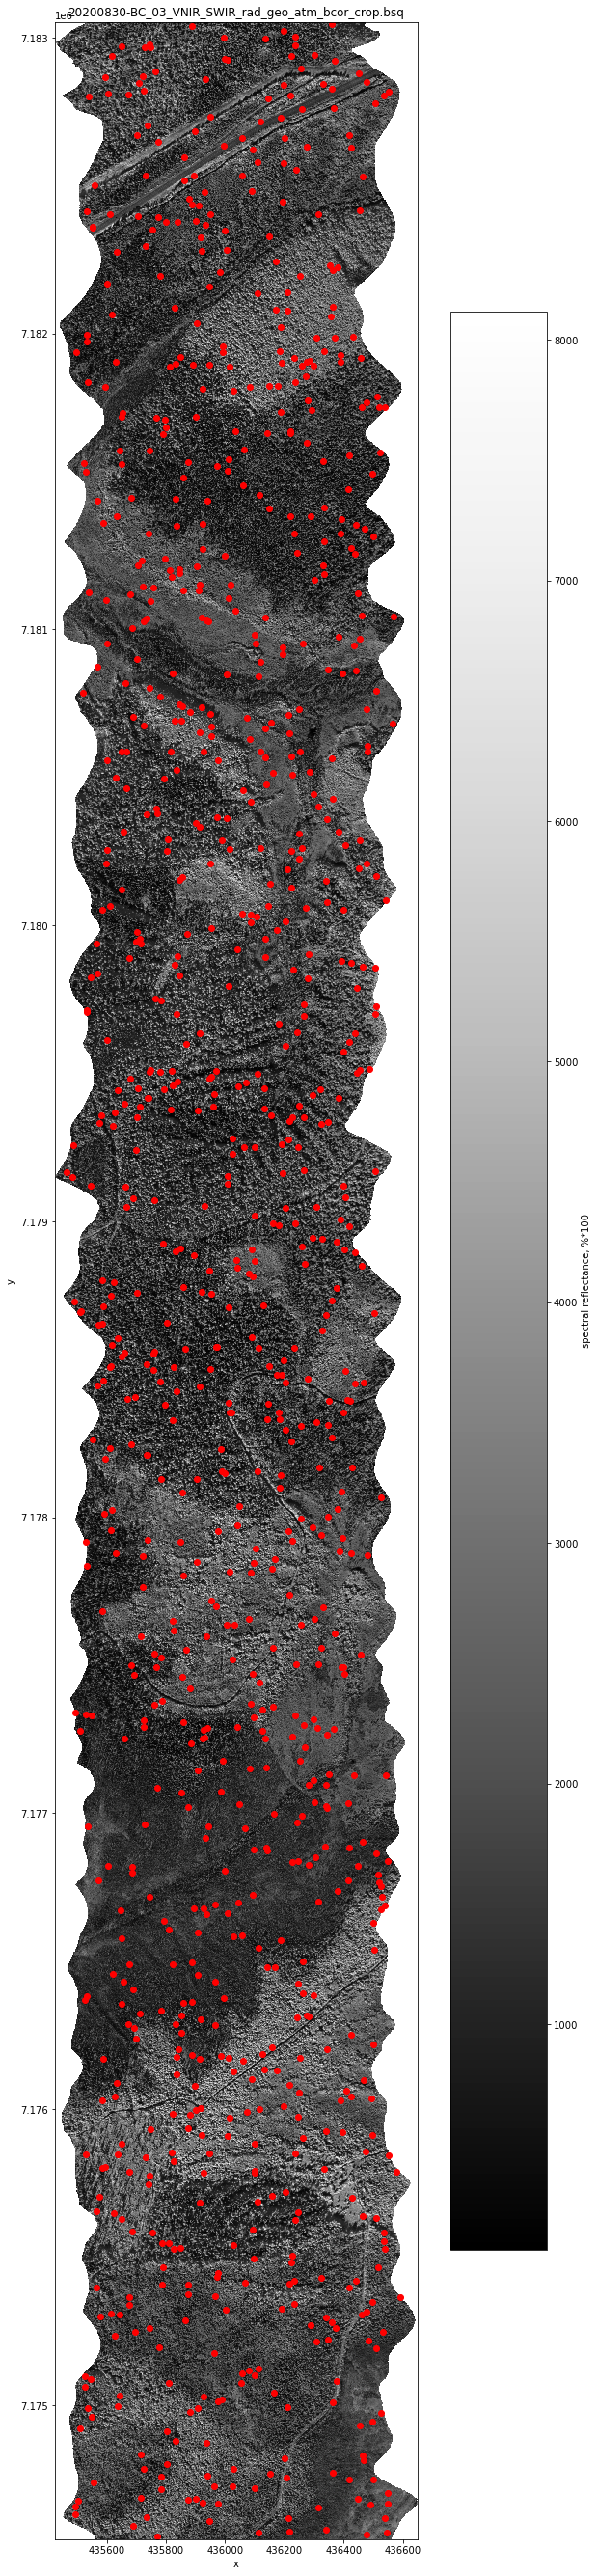

In [212]:
fig, ax = plt.subplots(figsize=(12, 48))
testdata.band_data.sel(band=141).plot(
    ax=ax, cmap="Greys_r")
ax.scatter(testdata.x[idx], testdata.y[idy], color='red')
ax.set_aspect('equal')
ax.set_title(testfile.parts[-1])

125


Text(0.5, 1.0, 'savgol length 5, polydegree 3')

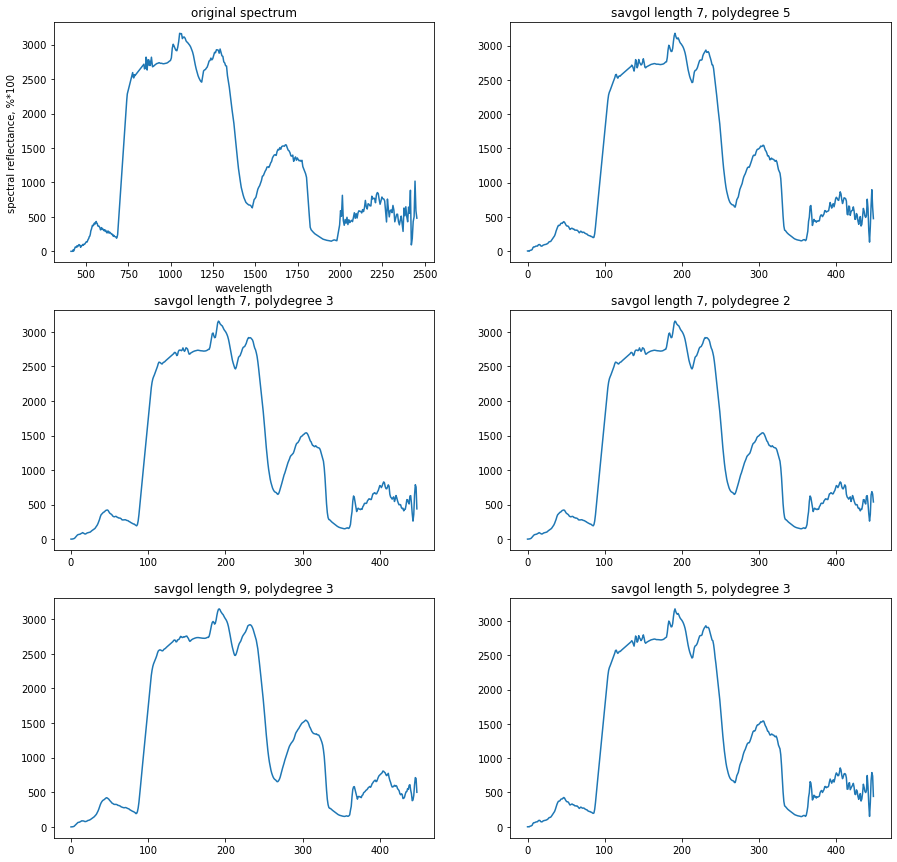

In [221]:
ii = np.random.randint(1000)
spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=testdata.x[ii], y=testdata.y[ii], method='nearest')[:-10]

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
print(ii)
spec.plot(ax=ax[0, 0])
ax[0, 0].set_title("original spectrum")
ax[0, 1].plot(savgol_filter(spec, 7, 5))
ax[1, 0].plot(savgol_filter(spec, 7, 3))
ax[1, 1].plot(savgol_filter(spec, 7, 2))
ax[2, 0].plot(savgol_filter(spec, 9, 3))
ax[2, 1].plot(savgol_filter(spec, 5, 3))
ax[0, 0].set_title("original spectrum")
ax[0, 1].set_title("savgol length 7, polydegree 5")
ax[1, 0].set_title("savgol length 7, polydegree 3")
ax[1, 1].set_title("savgol length 7, polydegree 2")
ax[2, 0].set_title("savgol length 9, polydegree 3")
ax[2, 1].set_title("savgol length 5, polydegree 3")

#ax[1, 0].plot(wav_bin, spec_bin, )
#ax[1, 1].plot(wav_bin, savgol_filter(spec_bin, 9, 2))

working on spectrum #1
working on spectrum #2
working on spectrum #3
working on spectrum #4
working on spectrum #5
working on spectrum #6
working on spectrum #7
working on spectrum #8
working on spectrum #9
working on spectrum #10
working on spectrum #11
working on spectrum #12
working on spectrum #13
working on spectrum #14
working on spectrum #15
working on spectrum #16
working on spectrum #17
working on spectrum #18
working on spectrum #19
working on spectrum #20
working on spectrum #21
working on spectrum #22
working on spectrum #23
working on spectrum #24
working on spectrum #25
working on spectrum #26
working on spectrum #27
working on spectrum #28
working on spectrum #29
working on spectrum #30
working on spectrum #31
working on spectrum #32
working on spectrum #33
working on spectrum #34
working on spectrum #35
working on spectrum #36
working on spectrum #37
working on spectrum #38
working on spectrum #39
working on spectrum #40
working on spectrum #41
working on spectrum #42
w

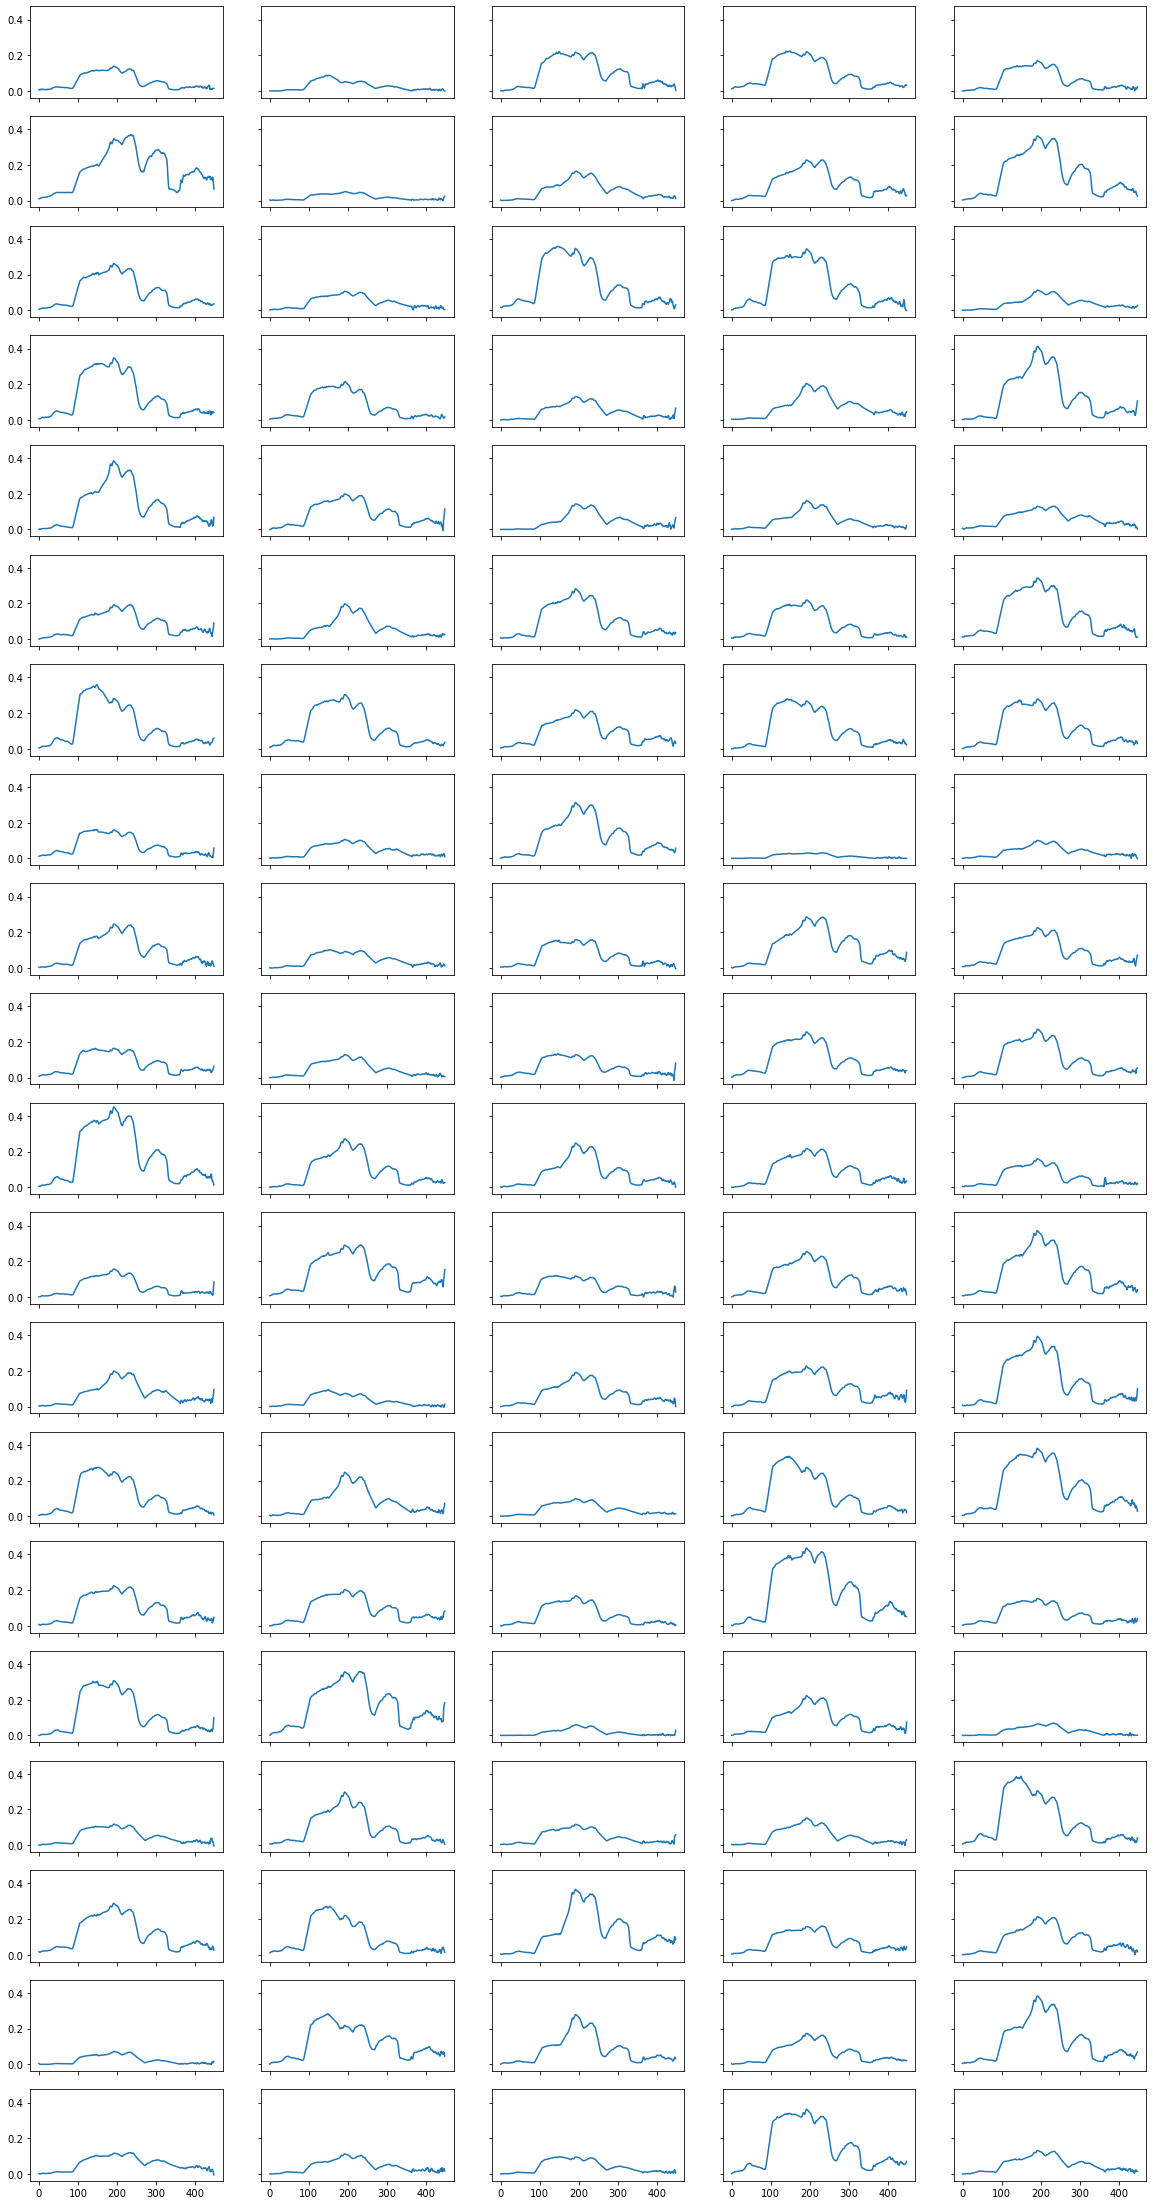

In [140]:
nmax = 20
mmax = 5

fig, axs = plt.subplots(nmax, mmax, figsize=(20, 40), sharex=True, sharey=True)
for ii, ax in enumerate(axs.flatten()):
        print(f"working on spectrum #{ii + 1}")
        spec = testdata.band_data.sel(x=testdata.x[idx[(ii)]], y=testdata.y[idy[ii]], method='nearest')[:-10]
#        spec.plot(ax=ax[ii, jj])
#ax[1, 0].plot(savgol_filter(spec.values, 7, 3))
        ax.plot(savgol_filter(spec.values, 7, 2)/10000)
#ax[1, 0].plot(wav_bin, spec_bin, )
#ax[1, 1].plot(wav_bin, savgol_filter(spec_bin, 9, 2))

In [262]:
xs = xr.DataArray(testdata.x[idx].values, dims="z")
ys = xr.DataArray(testdata.y[idy].values, dims="z")

sample = testdata.band_data.sel(x=xs, y=ys)
sample_df = sample.to_dataframe()
sample_df.drop(columns=['fwhm', 'wavelength', 'spatial_ref'], inplace=True)
sample_df.reset_index(inplace=True)
final_df = sample_df.pivot(index=['x', 'y'], columns='band', values='band_data')
final_df

,band,1,2,3,4,5,6,7,8,9,10,...,450,451,452,453,454,455,456,457,458,459
x,y,,,,,,,,,,,,,,,,,,,,,
435465.0,7179167.0,9.0,31.0,0.0,0.0,38.0,25.0,82.0,84.0,105.0,126.0,...,432.0,252.0,2501.0,734.0,606.0,4646.0,7003.0,2766.0,167.0,15000.0
435484.0,7179151.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,...,536.0,229.0,0.0,220.0,1.0,8130.0,1736.0,2824.0,8569.0,14989.0
435486.0,7179256.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,6.0,14.0,10.0,...,640.0,1159.0,254.0,276.0,1.0,2.0,2.0,14998.0,2.0,7615.0
435490.0,7178728.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,40.0,27.0,34.0,...,80.0,231.0,554.0,401.0,2617.0,6928.0,7326.0,1.0,5828.0,7656.0
435493.0,7174633.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,26.0,2.0,8.0,...,176.0,243.0,971.0,0.0,640.0,3.0,4276.0,2155.0,3.0,9640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436552.0,7175844.0,62.0,14.0,21.0,85.0,14.0,0.0,70.0,80.0,79.0,40.0,...,345.0,466.0,1426.0,658.0,2509.0,1603.0,12518.0,306.0,8903.0,442.0
436565.0,7180683.0,20.0,33.0,33.0,20.0,51.0,96.0,54.0,92.0,91.0,70.0,...,1129.0,672.0,1632.0,1190.0,3458.0,8278.0,15000.0,9190.0,4532.0,15000.0
436570.0,7181043.0,27.0,29.0,39.0,52.0,33.0,35.0,55.0,76.0,33.0,38.0,...,438.0,540.0,791.0,472.0,3293.0,1228.0,5185.0,918.0,1013.0,3390.0


In [265]:
final_df.columns = final_df.columns.astype('str')

In [270]:
final_df.columns.name = 'sample'

In [271]:
outdir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/")
final_df.reset_index().to_feather(outdir / f"{testfile.stem}_samplespectra.fth")

In [272]:
final_df.corr()

sample,1,2,3,4,5,6,7,8,9,10,...,450,451,452,453,454,455,456,457,458,459
sample,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.833621,0.854926,0.854017,0.849460,0.843098,0.838520,0.833463,0.826276,0.840170,...,0.306290,0.303186,0.225586,0.208842,0.099502,0.136849,0.101797,0.129010,0.105562,0.104689
2,0.833621,1.000000,0.855727,0.869211,0.872299,0.875425,0.868621,0.865681,0.861017,0.876660,...,0.314525,0.313607,0.210514,0.207409,0.090481,0.149932,0.091584,0.145872,0.083149,0.093616
3,0.854926,0.855727,1.000000,0.869781,0.884125,0.880537,0.859006,0.864247,0.861929,0.871574,...,0.345713,0.294127,0.192810,0.180997,0.081964,0.118703,0.046461,0.105425,0.061470,0.087161
4,0.854017,0.869211,0.869781,1.000000,0.889127,0.890289,0.881248,0.884299,0.886675,0.896885,...,0.332594,0.291379,0.206604,0.185308,0.074333,0.142980,0.077847,0.122950,0.079365,0.084117
5,0.849460,0.872299,0.884125,0.889127,1.000000,0.904866,0.898998,0.903095,0.908781,0.914635,...,0.363549,0.311112,0.220240,0.215924,0.100143,0.148639,0.075513,0.139629,0.084748,0.109041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.136849,0.149932,0.118703,0.142980,0.148639,0.147316,0.168272,0.159684,0.160277,0.162723,...,0.160938,0.205709,0.189682,0.178455,0.197651,1.000000,0.166611,0.190898,0.167071,0.160072
456,0.101797,0.091584,0.046461,0.077847,0.075513,0.086261,0.094324,0.098213,0.090242,0.085217,...,0.180758,0.187646,0.198571,0.217017,0.213694,0.166611,1.000000,0.199130,0.202535,0.217970
457,0.129010,0.145872,0.105425,0.122950,0.139629,0.122813,0.156393,0.156191,0.130190,0.140735,...,0.231718,0.274313,0.205879,0.205787,0.226202,0.190898,0.199130,1.000000,0.178585,0.173241


In [234]:
sb.set(rc = {'figure.figsize':(18,15)})
sb.set_context("poster")

<AxesSubplot:xlabel='band', ylabel='band'>

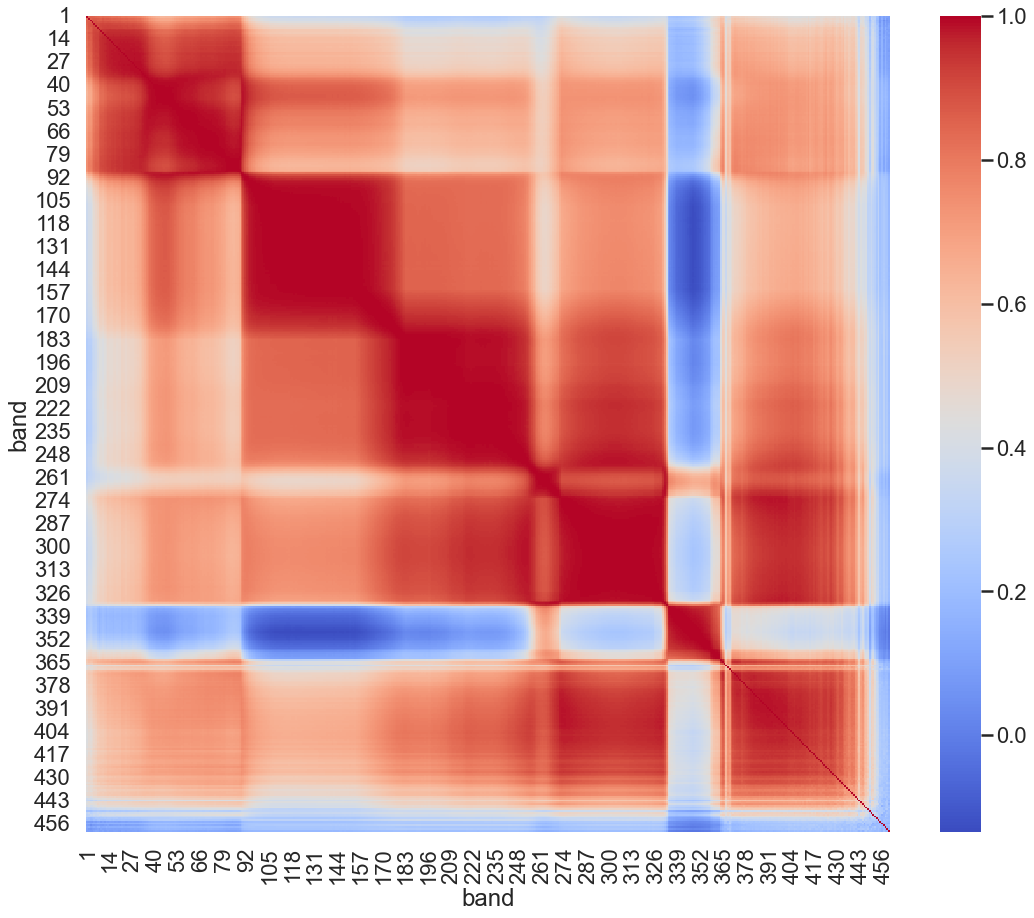

In [235]:
sb.heatmap(final_df.corr(), cmap='coolwarm')

---

### Loop through directory of flightline

In [6]:
datadir = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/")
prefix = '20210803-BC'
filepatt = f"VNIR_SWIR_rad_geo_atm_bcor_crop.bsq"
outdir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/")


In [7]:
outdir

PosixPath('/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted')

In [25]:
for flightline in [3]:
    lineno = str(flightline).zfill(2)
    fn = f"{prefix}_{lineno}_{filepatt}"
    print(f"Working on {fn}")
    testfile = datadir / fn
    testdata = xr.open_dataset(testfile, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400})
    
    # random sampling
    print("    random sampling") 
    rng = np.random.default_rng(2021)
    selectionarray = testdata.band_data.sel(band=1).to_masked_array(copy=False)
    weights = ~selectionarray.mask + 0 # Assign False = 0, True = 1
    normalized = weights.ravel() / float(weights.sum())
    index = rng.choice(
        selectionarray.size, 
        size=1000, 
        replace=False, 
        p=normalized
    )        
    idy, idx = np.unravel_index(index, selectionarray.shape)
    
    # extracting spectra
    print("    extracting spectra") 
    xs = xr.DataArray(testdata.x[idx].values, dims="z")
    ys = xr.DataArray(testdata.y[idy].values, dims="z")
    sample = testdata.band_data.sel(x=xs, y=ys)
    
    # creating output dataframe
    print("    creating dataframe") 
    sample_df = sample.to_dataframe()
    sample_df.drop(columns=['fwhm', 'wavelength', 'spatial_ref'], inplace=True)
    sample_df.reset_index(inplace=True)
    final_df = sample_df.pivot(index=['x', 'y'], columns='band', values='band_data')
    final_df.columns = final_df.columns.astype('str')
    final_df.columns.name = 'sample'
    print(final_df)
    
    # writing output
    print("    writing output") 
    final_df.reset_index().to_feather(outdir / f"{testfile.stem}_samplespectra.fth")
    
    # close dataset
    testdata.close()

Working on 20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
    random sampling
    extracting spectra
    creating dataframe
sample                  1      2      3      4      5      6      7      8  \
x        y                                                                   
436683.0 7177875.0   38.0   50.0   42.0   28.0   48.0   35.0   13.0   27.0   
436719.0 7175859.0   61.0   84.0   45.0   65.0   66.0   86.0  100.0   98.0   
436722.0 7176003.0   44.0   15.0   20.0   72.0   46.0   28.0   73.0   34.0   
436723.0 7176528.0  231.0  181.0  176.0  210.0  170.0  189.0  226.0  230.0   
436728.0 7175437.0  103.0   94.0   45.0   85.0   90.0   44.0   84.0   82.0   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
437701.0 7178392.0  168.0  164.0  165.0  177.0  151.0  186.0  224.0  235.0   
437702.0 7180868.0  107.0  116.0  147.0  163.0  184.0  191.0  196.0  250.0   
437751.0 7179429.0   81.0  107.0   59.0   82.0  104.0  110.0  133.0  128.0   
437761.0 71805